In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from core.utils.GAN_utils import BigGAN_wrapper, Caffenet, loadBigGAN
from core.utils.layer_hook_utils import featureFetcher_module, featureFetcher
from core.utils.plot_utils import to_imgrid, make_grid, show_imgrid


c:\Users\ponce\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_biggan import BigGAN, one_hot_from_names, truncated_noise_sample, one_hot_from_int
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, TensorDataset
from core.utils.GAN_utils import Caffenet  # Assuming Caffenet is defined in your utils
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Initialize Caffenet
caffenet_model = Caffenet()
caffenet_model.to(device)
caffenet_model.eval()

# Initialize BigGAN
BG = loadBigGAN()
BG.to(device).eval()
G = BigGAN_wrapper(BG)

In [5]:
# Sampling 5000 random latent codes
num_samples = 5000
latent_dim = 128  # BigGAN latent dimension
truncation = 0.7
latent_codes = truncated_noise_sample(truncation=truncation, batch_size=num_samples)
noise_latent_codes = torch.tensor(latent_codes, dtype=torch.float32).to(device)
class_ids = torch.randint(0, 1000, (num_samples,))
class_ids_one_hot = F.one_hot(class_ids, num_classes=1000)
# to one hot
class_latent_codes = G.BigGAN.embeddings(class_ids_one_hot.float().to(device))
print(class_latent_codes.shape) 
print(noise_latent_codes.shape)
latent_codes_all = torch.cat([noise_latent_codes, class_latent_codes], dim=1)

torch.Size([5000, 128])
torch.Size([5000, 128])


### Testing this 

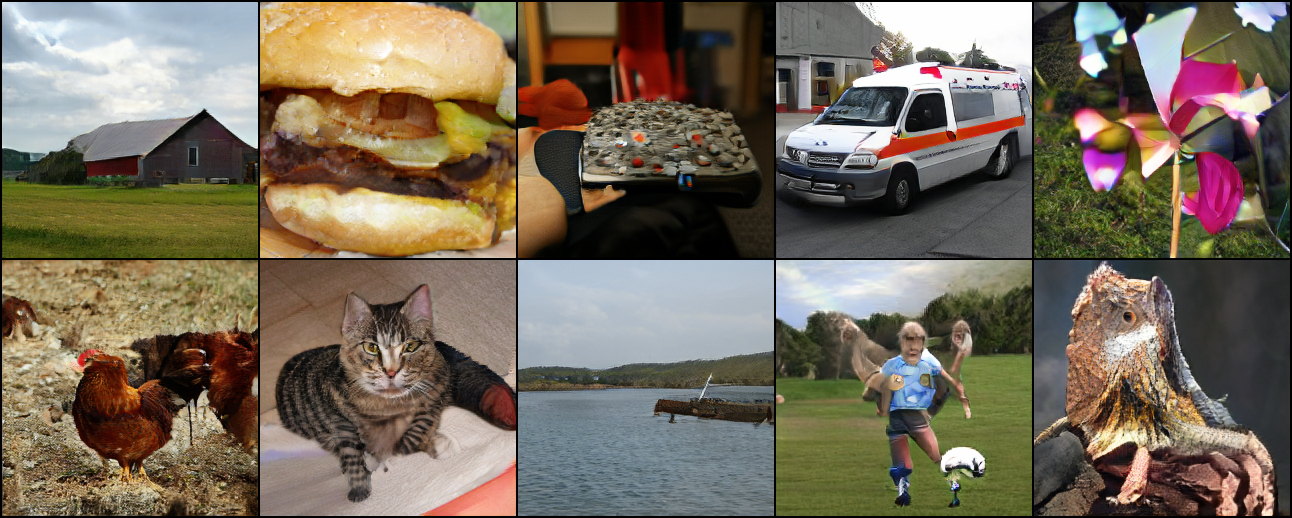

Image 0: Class ID 425 - barn
Image 1: Class ID 933 - cheeseburger
Image 2: Class ID 761 - remote_control
Image 3: Class ID 407 - ambulance
Image 4: Class ID 723 - pinwheel
Image 5: Class ID 8 - hen
Image 6: Class ID 281 - tabby
Image 7: Class ID 913 - wreck
Image 8: Class ID 805 - soccer_ball
Image 9: Class ID 43 - frilled_lizard


In [6]:
import json
import urllib.request

# Download ImageNet class index
url = "https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json"
response = urllib.request.urlopen(url)
imagenet_classes = json.loads(response.read())

latent_codes_all = torch.cat([noise_latent_codes, class_latent_codes], dim=1)
with torch.no_grad():
    imgs = G.visualize(latent_codes_all[:10])
    
display(to_imgrid(imgs, nrow=5))

for i in range(10):
    class_id = class_ids[i].item()
    class_name = imagenet_classes[str(class_id)][1]  # Get human readable class name
    print(f"Image {i}: Class ID {class_id} - {class_name}")


### Streaming and recording activations


In [8]:
from tqdm.auto import trange, tqdm
from collections import defaultdict

In [12]:
caffenet_model.net

Sequential(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (norm1): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (norm2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1.0)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace=True)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu4): ReLU(inplace=True)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  (relu5): ReLU(inplace=True)
  (pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  

In [13]:
fetcher = featureFetcher_module()

for name, layer in caffenet_model.net.named_children():
    if name == "flatten":
        continue
    fetcher.record_module(layer, name, ingraph=False, store_device="cpu")


In [18]:
def get_center_activation(tensor, max_channel=None):
    if max_channel is None:
        max_channel = tensor.shape[1]
    if len(tensor.shape) == 2:
        return tensor[:, :max_channel]
    elif len(tensor.shape) == 4:
        B, C, H, W = tensor.shape
        return tensor[:, :max_channel, H//2, W//2]
    else:
        raise ValueError(f"Expected tensor with 2 or 4 dimensions, got {len(tensor.shape)}")

In [21]:
# Define transformation to match Caffenet input requirements
transform = transforms.Compose([
    transforms.Resize(224),
    # Note no need to normalize, as the model perform normalization inside
])

activation_storage = defaultdict(list)

# Create DataLoader for batch processing
batch_size = 25
for csr in trange(0, len(latent_codes_all), batch_size):
    latent_codes_all_batch = latent_codes_all[csr:csr+batch_size]
    imgs = G.visualize(latent_codes_all_batch)
    imgs = transform(imgs)
    with torch.no_grad():
        _ = caffenet_model(imgs, preproc=True)
    
    for name, activation in fetcher.activations.items():
        activation_storage[name].append(get_center_activation(activation))

# Concatenate activations
for layer in activation_storage:
    activation_storage[layer] = torch.cat(activation_storage[layer], dim=0)

100%|██████████| 200/200 [02:11<00:00,  1.52it/s]


In [26]:
for layer in activation_storage:
    print(layer, activation_storage[layer].shape)

conv1 torch.Size([5000, 96])
relu1 torch.Size([5000, 96])
pool1 torch.Size([5000, 96])
norm1 torch.Size([5000, 96])
conv2 torch.Size([5000, 256])
relu2 torch.Size([5000, 256])
pool2 torch.Size([5000, 256])
norm2 torch.Size([5000, 256])
conv3 torch.Size([5000, 384])
relu3 torch.Size([5000, 384])
conv4 torch.Size([5000, 384])
relu4 torch.Size([5000, 384])
conv5 torch.Size([5000, 256])
relu5 torch.Size([5000, 256])
pool5 torch.Size([5000, 256])
fc6 torch.Size([5000, 4096])
relu6 torch.Size([5000, 4096])
fc7 torch.Size([5000, 4096])
relu7 torch.Size([5000, 4096])
fc8 torch.Size([5000, 1000])


In [31]:
X = latent_codes_all.cpu().numpy()
results = []

for layer, activation in activation_storage.items():
    # For each target neuron in the layer
    target_idx = np.arange(activation.shape[1])
    y = activation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_noise = X_train[:, :128]
    X_train_class = X_train[:, 128:]
    X_test_noise = X_test[:, :128]
    X_test_class = X_test[:, 128:]
    # Ridge Regression
    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train, y_train)
    # Calculate R2 score for each target neuron using vectorized operation
    r2_train = r2_score(y_train, ridge.predict(X_train), multioutput='raw_values')
    r2_scores = r2_score(y_test, ridge.predict(X_test), multioutput='raw_values')
    
    ridge_class = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train_class, y_train)
    r2_scores_class = r2_score(y_test, ridge_class.predict(X_test_class), multioutput='raw_values')
    r2_train_class = r2_score(y_train, ridge_class.predict(X_train_class), multioutput='raw_values')

    ridge_noise = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train_noise, y_train)
    r2_scores_noise = r2_score(y_test, ridge_noise.predict(X_test_noise), multioutput='raw_values')
    r2_train_noise = r2_score(y_train, ridge_noise.predict(X_train_noise), multioutput='raw_values')
    # Create dictionary entries for all targets at once

    results.extend([{
        'Layer': layer,
        'Target': idx,
        'Train_R2': r2_train[idx],
        'Test_R2': r2_scores[idx],
        'Train_R2_class': r2_train_class[idx],
        'Test_R2_class': r2_scores_class[idx],
        'Train_R2_noise': r2_train_noise[idx],
        'Test_R2_noise': r2_scores_noise[idx]
    } for idx in zip(target_idx)])


# Summarize results
results_df = pd.DataFrame(results)

In [55]:
from core.utils.plot_utils import saveallforms


In [54]:
import pickle as pkl
from os.path import join
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\BigGAN_Caffenet"
os.makedirs(savedir, exist_ok=True)

# Save the full results DataFrame
results_df.to_csv(join(savedir, "latent_code_linearity_results.csv"), index=False)

# Save summary statistics per layer
layer_summary = results_df.groupby('Layer').agg({
    'Test_R2': ['mean', 'std', 'median'],
    'Test_R2_class': ['mean', 'std', 'median'], 
    'Test_R2_noise': ['mean', 'std', 'median']
}).round(4)
layer_summary.to_csv(join(savedir, "layer_summary_stats.csv"))

# Save the raw data used for analysis
pkl.dump({"latent_codes": latent_codes_all.cpu(), 
          "class_ids": class_ids.cpu(),
          "activation_storage": activation_storage}, open(join(savedir, "BigGAN_Caffenet_data.pkl"), "wb"))

In [76]:
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\BigGAN_Caffenet"
results_df = pd.read_csv(join(savedir, "latent_code_linearity_results.csv"))

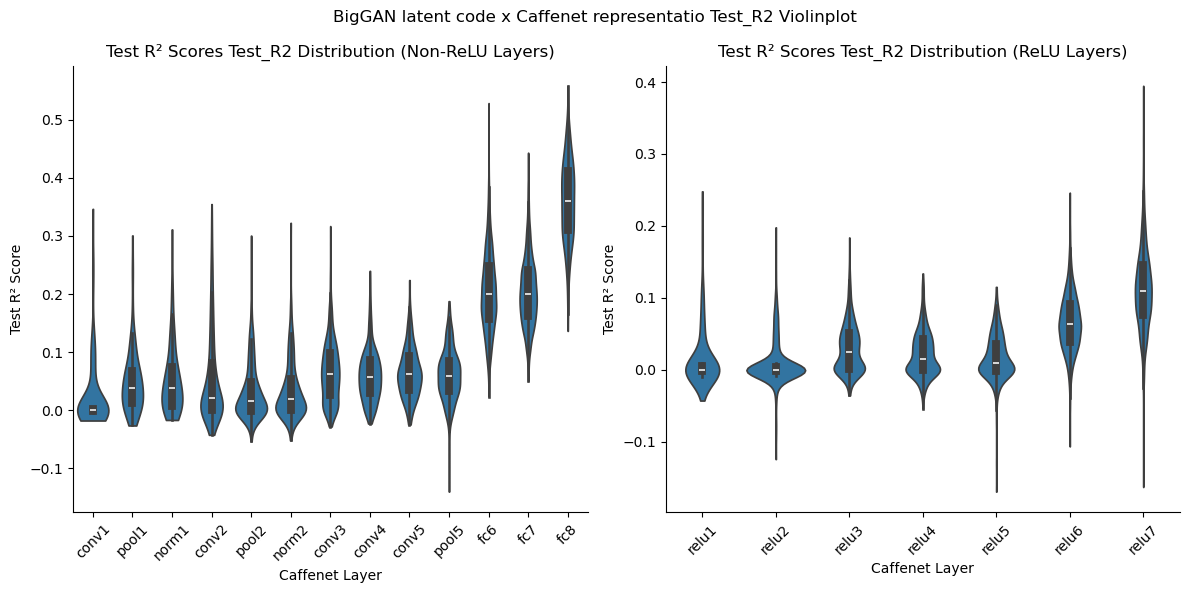

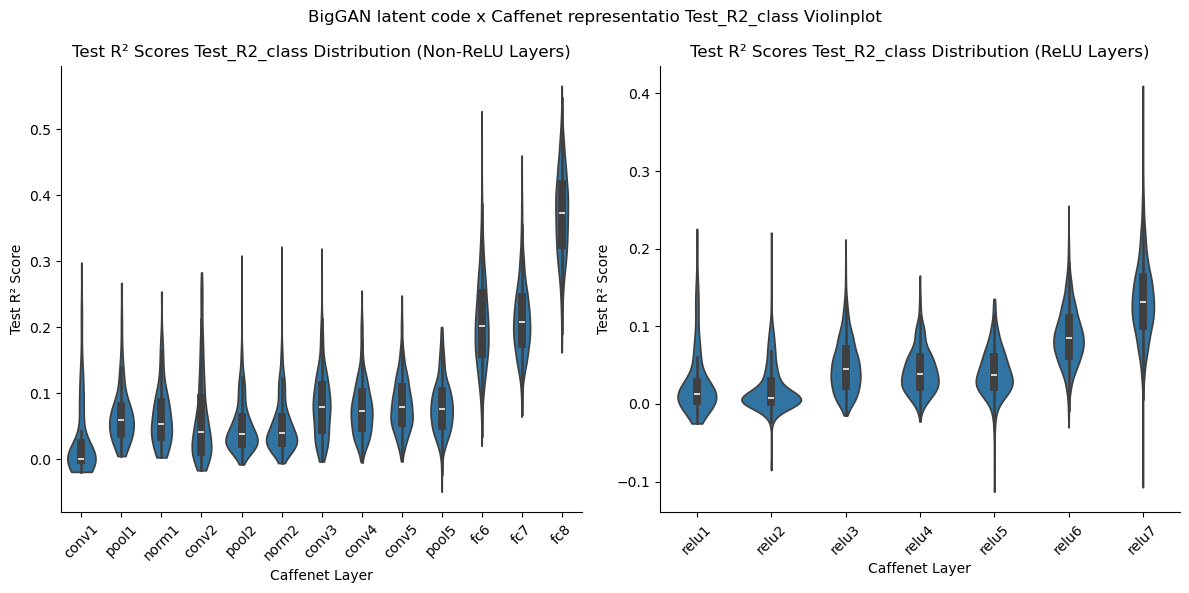

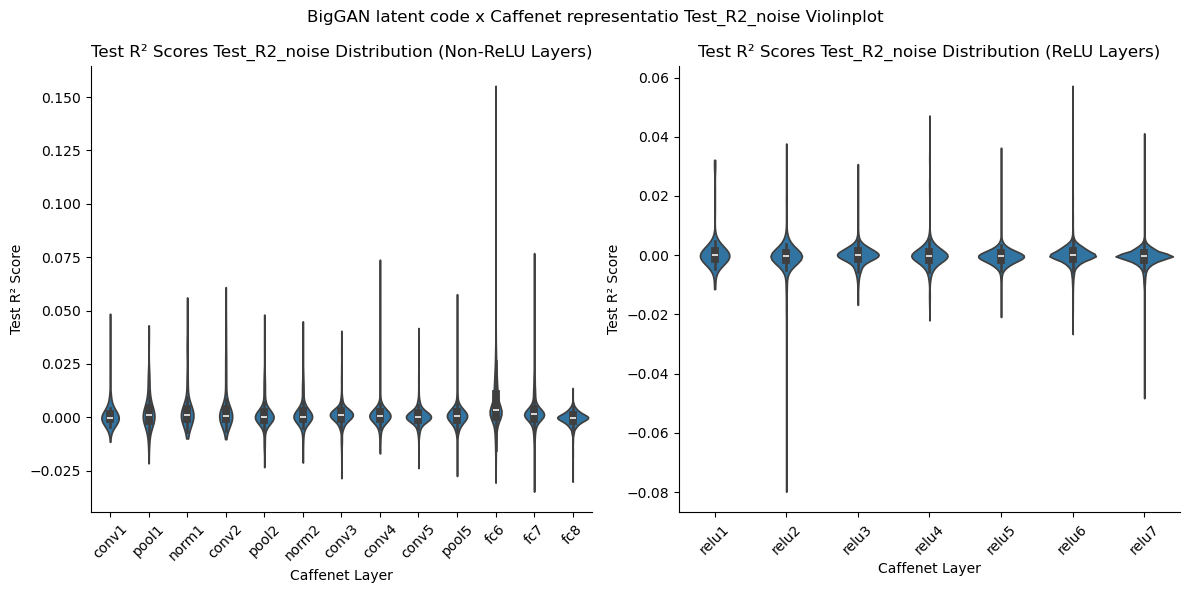

In [77]:
# Plot the results
for y_variable in ["Test_R2", 'Test_R2_class', 'Test_R2_noise']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.violinplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1, cut=0)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.violinplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2, cut=0)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    plt.suptitle(f"BigGAN latent code x Caffenet representatio {y_variable} Violinplot")
    plt.tight_layout()
    saveallforms(savedir, f"BigGAN_Caffenet_{y_variable}_violinplot")
    plt.show()


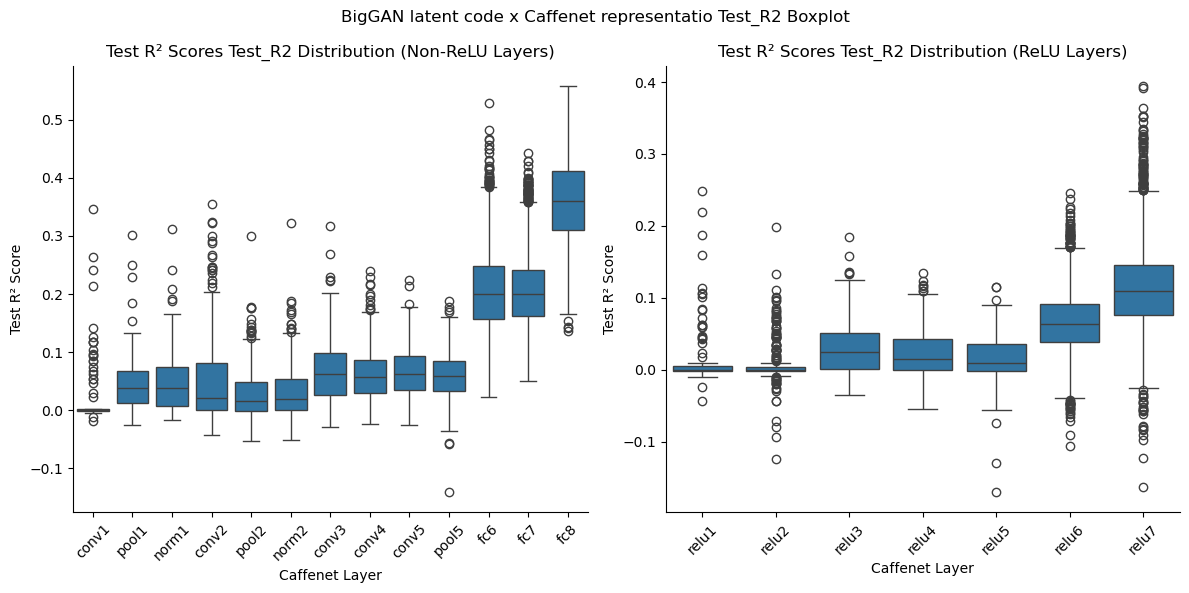

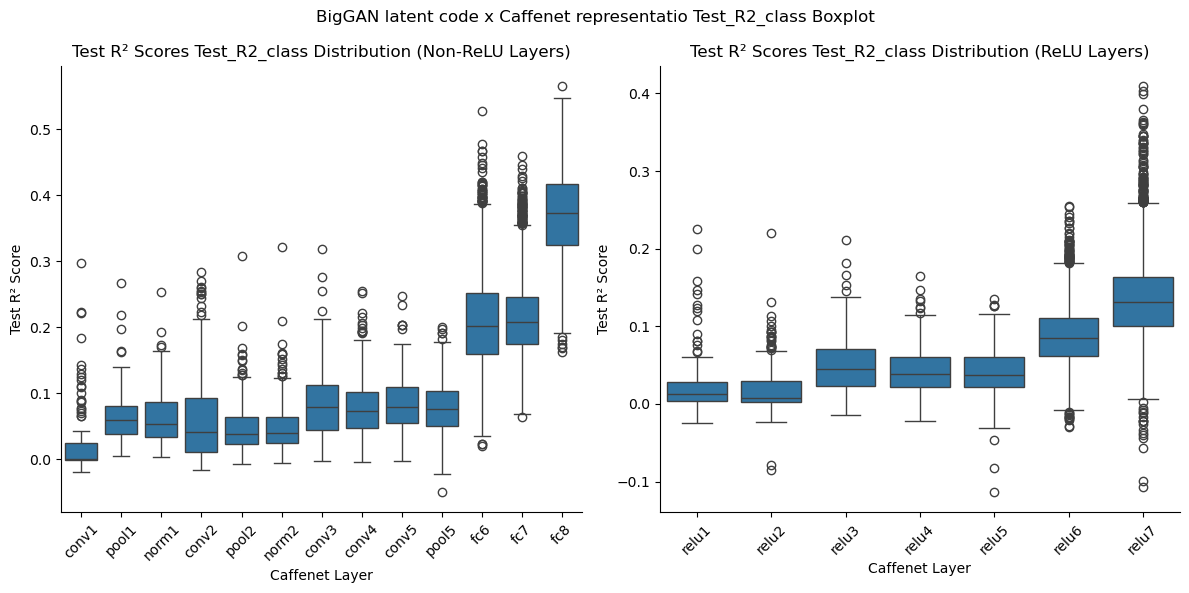

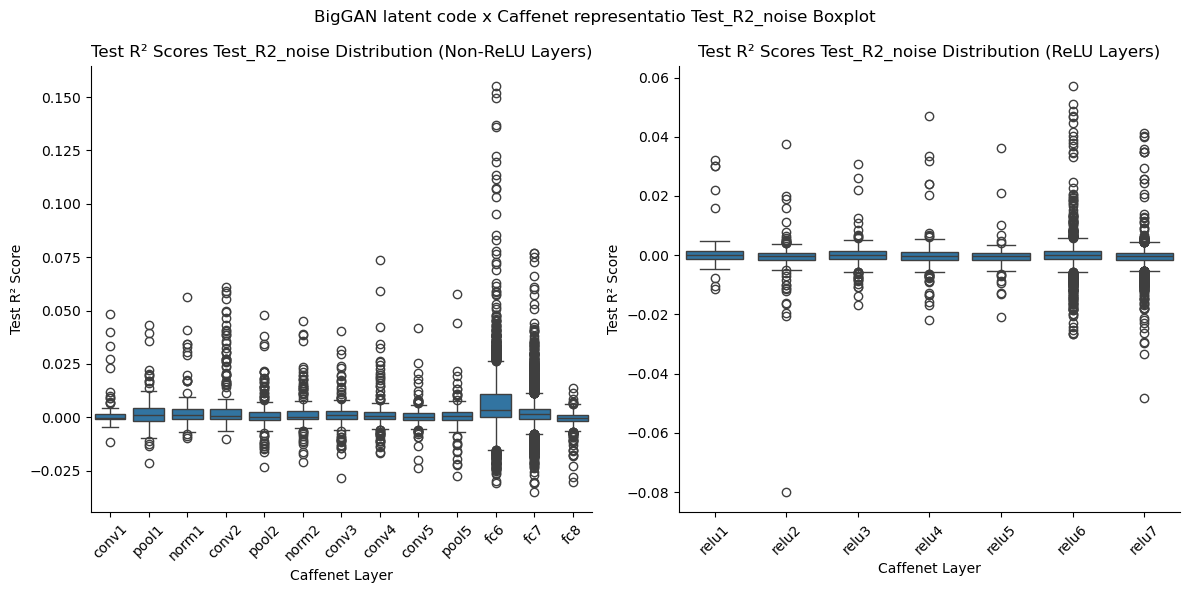

In [78]:
# Plot the results
for y_variable in ["Test_R2", 'Test_R2_class', 'Test_R2_noise']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.boxplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1, )
    ax1.tick_params(axis='x', rotation=45)

    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.boxplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2, )
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    plt.suptitle(f"BigGAN latent code x Caffenet representatio {y_variable} Boxplot")
    plt.tight_layout()
    saveallforms(savedir, f"BigGAN_Caffenet_{y_variable}_boxplot")
    plt.show()

### DeePSim CaffeNet    

In [59]:
from tqdm.auto import trange, tqdm
from collections import defaultdict
from core.utils.GAN_utils import upconvGAN


In [63]:
def get_center_activation(tensor, max_channel=None):
    if max_channel is None:
        max_channel = tensor.shape[1]
    if len(tensor.shape) == 2:
        return tensor[:, :max_channel]
    elif len(tensor.shape) == 4:
        B, C, H, W = tensor.shape
        return tensor[:, :max_channel, H//2, W//2]
    else:
        raise ValueError(f"Expected tensor with 2 or 4 dimensions, got {len(tensor.shape)}")

In [60]:
# Initialize Caffenet
caffenet_model = Caffenet()
caffenet_model.to(device)
caffenet_model.eval()

# Initialize BigGAN
DP_G = upconvGAN("fc6").to(device).eval()


In [79]:
# Sampling 5000 random latent codes
num_samples = 5000
latent_codes_all = 4 * torch.randn(num_samples, 4096).to(device)

In [80]:
fetcher = featureFetcher_module()

for name, layer in caffenet_model.net.named_children():
    if name == "flatten":
        continue
    fetcher.record_module(layer, name, ingraph=False, store_device="cpu")


In [81]:
# Define transformation to match Caffenet input requirements
transform = transforms.Compose([
    transforms.Resize(224),
    # Note no need to normalize, as the model perform normalization inside
])

activation_storage = defaultdict(list)

# Create DataLoader for batch processing
batch_size = 50
for csr in trange(0, len(latent_codes_all), batch_size):
    latent_codes_all_batch = latent_codes_all[csr:csr+batch_size]
    imgs = DP_G.visualize(latent_codes_all_batch)
    imgs = transform(imgs)
    with torch.no_grad():
        _ = caffenet_model(imgs, preproc=True)
    
    for name, activation in fetcher.activations.items():
        activation_storage[name].append(get_center_activation(activation))

# Concatenate activations
for layer in activation_storage:
    activation_storage[layer] = torch.cat(activation_storage[layer], dim=0)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 100/100 [00:33<00:00,  2.97it/s]


In [82]:
for layer in activation_storage:
    print(layer, activation_storage[layer].shape)

conv1 torch.Size([5000, 96])
relu1 torch.Size([5000, 96])
pool1 torch.Size([5000, 96])
norm1 torch.Size([5000, 96])
conv2 torch.Size([5000, 256])
relu2 torch.Size([5000, 256])
pool2 torch.Size([5000, 256])
norm2 torch.Size([5000, 256])
conv3 torch.Size([5000, 384])
relu3 torch.Size([5000, 384])
conv4 torch.Size([5000, 384])
relu4 torch.Size([5000, 384])
conv5 torch.Size([5000, 256])
relu5 torch.Size([5000, 256])
pool5 torch.Size([5000, 256])
fc6 torch.Size([5000, 4096])
relu6 torch.Size([5000, 4096])
fc7 torch.Size([5000, 4096])
relu7 torch.Size([5000, 4096])
fc8 torch.Size([5000, 1000])


In [ ]:
# Load the Hessian eigenspace 

In [83]:
X = latent_codes_all.cpu().numpy()
results = []

for layer, activation in activation_storage.items():
    # For each target neuron in the layer
    target_idx = np.arange(activation.shape[1])
    y = activation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Ridge Regression
    ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), alpha_per_target=True).fit(X_train, y_train)
    # Calculate R2 score for each target neuron using vectorized operation
    r2_train = r2_score(y_train, ridge.predict(X_train), multioutput='raw_values')
    r2_scores = r2_score(y_test, ridge.predict(X_test), multioutput='raw_values')
    
    # Create dictionary entries for all targets at once
    results.extend([{
        'Layer': layer,
        'Target': idx,
        'Train_R2': r2_train[idx],
        'Test_R2': r2_scores[idx],
    } for idx in zip(target_idx)])


# Summarize results
results_df = pd.DataFrame(results)

In [84]:
import pickle as pkl
from os.path import join
from core.utils.plot_utils import saveallforms
savedir = r"E:\OneDrive - Harvard University\Manuscript_BigGAN\Figures\insilico_latent_code_linearity\DeePSim_FC6_Caffenet"
os.makedirs(savedir, exist_ok=True)

# Save the full results DataFrame
results_df.to_csv(join(savedir, "latent_code_linearity_results.csv"), index=False)

# Save summary statistics per layer
layer_summary = results_df.groupby('Layer').agg({
    'Test_R2': ['mean', 'std', 'median'],

}).round(4)
layer_summary.to_csv(join(savedir, "layer_summary_stats.csv"))

# Save the raw data used for analysis
pkl.dump({"latent_codes": latent_codes_all.cpu(), 
          "activation_storage": activation_storage}, open(join(savedir, "DeePSim_FC6_Caffenet_data.pkl"), "wb"))

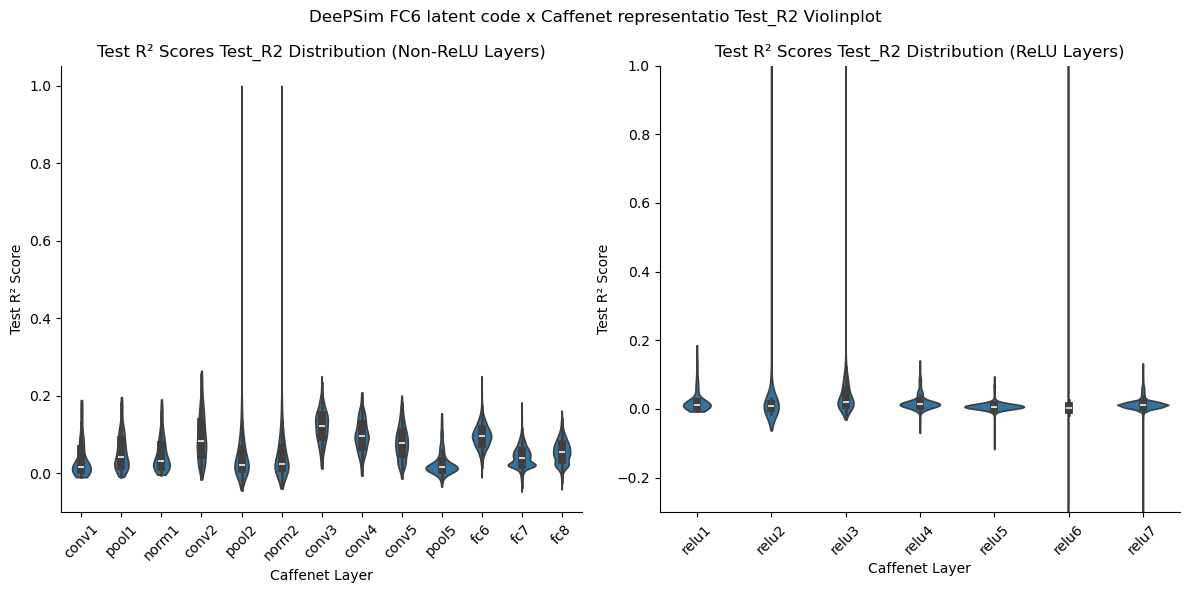

In [85]:
# Plot the results
for y_variable in ["Test_R2", ]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.violinplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1, cut=0)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.violinplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2, cut=0)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    # clip y axis
    ax2.set_ylim(-0.3, 1)
    plt.suptitle(f"DeePSim FC6 latent code x Caffenet representatio {y_variable} Violinplot")
    plt.tight_layout()
    saveallforms(savedir, f"DeePSim_FC6_Caffenet_{y_variable}_violinplot")
    plt.show()

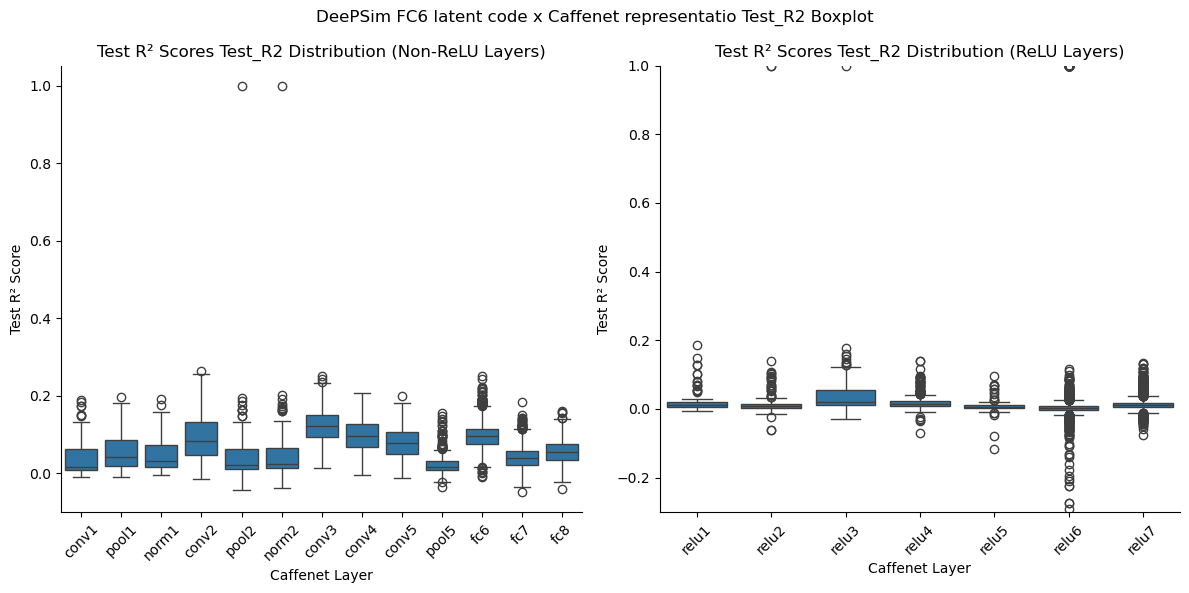

In [86]:
# Plot the results
for y_variable in ["Test_R2", ]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Plot for layers without relu
    sns.boxplot(x='Layer', y=y_variable, 
            data=results_df.query('not Layer.str.contains("relu")'), 
            ax=ax1)
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_title(f'Test R² Scores {y_variable} Distribution (Non-ReLU Layers)')
    ax1.set_xlabel('Caffenet Layer')
    ax1.set_ylabel('Test R² Score')

    # Plot for relu layers
    sns.boxplot(x='Layer', y=y_variable,
            data=results_df.query('Layer.str.contains("relu")'),
            ax=ax2)
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_title(f'Test R² Scores {y_variable} Distribution (ReLU Layers)')
    ax2.set_xlabel('Caffenet Layer')
    ax2.set_ylabel('Test R² Score')
    # clip y axis
    ax2.set_ylim(-0.3, 1)
    plt.suptitle(f"DeePSim FC6 latent code x Caffenet representatio {y_variable} Boxplot")
    plt.tight_layout()
    saveallforms(savedir, f"DeePSim_FC6_Caffenet_{y_variable}_boxplot")
    plt.show()